# Data Preprocessing

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import pickle
from random import shuffle
import matplotlib.pyplot as plt
import datetime

C:\Users\kabil\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
dataset = os.path.join(os.getcwd(), "pdataset")
data = []
for i , value in enumerate(os.listdir(dataset)):
    f_dir = os.path.join(dataset,value)
    for each in os.listdir(f_dir):
        image = cv2.imread(os.path.join(f_dir,each),0)
        image = cv2.resize(image,(200,200))
        data.append((image,i))

In [3]:
shuffle(data)
x = []
y = []
for features , label in data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(-1,200,200,1)
pickle_out = open("X.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

# Training

In [4]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [32]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(128))

model.add(Dense(64))

model.add(Dense(32))

model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

logdir = "logs\\scalars\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
model.fit(X, y, batch_size=32, epochs=10, validation_split=0.3,  callbacks=[tensorboard_callback])

model.save("model.h5")

Train on 540 samples, validate on 232 samples
Epoch 1/10
540/540 [==============================] - 23s 42ms/sample - loss: 0.7091 - acc: 0.6130 - val_loss: 0.6712 - val_acc: 0.6810
Epoch 2/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6759 - acc: 0.6130 - val_loss: 0.6382 - val_acc: 0.6810
Epoch 3/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6659 - acc: 0.6130 - val_loss: 0.6236 - val_acc: 0.6810
Epoch 4/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6650 - acc: 0.6130 - val_loss: 0.6430 - val_acc: 0.6810
Epoch 5/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6449 - acc: 0.6093 - val_loss: 0.6002 - val_acc: 0.6681
Epoch 6/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6079 - acc: 0.6130 - val_loss: 0.5994 - val_acc: 0.6810
Epoch 7/10
540/540 [==============================] - 11s 21ms/sample - loss: 0.6003 - acc: 0.6426 - val_loss: 0.6454 - val_acc: 0.6250
Ep

# Testing

In [14]:
model = tf.keras.models.load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 64)      640       
_________________________________________________________________
activation_3 (Activation)    (None, 198, 198, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
activation_4 (Activation)    (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)           

In [15]:
def test(path):
    image = cv2.imread(path,1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray,(5,5),0)
    min_x = image.shape[0]
    min_y = image.shape[1]
    max_x = 0
    max_y = 0
    canny = cv2.Canny(blurred,0,250)
    (cnts,_) = cv2.findContours(canny.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    coints = image.copy()
    frame = image.copy()
    cv2.drawContours(frame,cnts,-1,(255,0,0),2)
    for cnt in cnts:
        x ,y,w,h = cv2.boundingRect(cnt)
        area = w * h
        if area > ((image.shape[0] * image.shape[1]) * 0.2):
            if min_x > x:
                min_x = x
            if min_y > y:
                min_y = y
            if max_x < (x + w):
                max_x = x + w
            if max_y < (y + h):
                max_y = y +h
    cv2.rectangle(coints,(min_x,min_y),(max_x,max_y),(0,255,0),2)
    roi = gray[min_y:max_y,min_x:max_x]
    image = cv2.resize(roi,(200,200))
    x = np.array(image).reshape(-1,200,200,1)
    y = model.predict(x)
    print(y[0][0])

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
def ptest(path):
    image = cv2.imread(path,0)
    image = cv2.resize(image,(200,200))
    x = np.array(image).reshape(-1,200,200,1)
    y = model.predict(x)
    print(y)

In [28]:
for i , each in enumerate(os.listdir("ptest")):
    print(each,f"expected {i} : observerd ->")

    for file in os.listdir(f"ptest/{each}"):
        print(file)
        ptest(f"ptest/{each}/"+file)


normal expected 0 : observerd ->
26.jpg
[[0.]]
32.jpg
[[0.]]
70.jpg
[[0.]]
stroke expected 1 : observerd ->
103.jpg
[[1.]]
148.jpg
[[0.]]
249.jpg
[[1.]]
253.jpg
[[1.]]
278.jpg
[[1.]]


In [30]:
for layer in model.layers:
        weights, bias= layer.get_weights()
        
        f_min, f_max = weights.min(), weights.max()
        
        filters = (weights - f_min) / (f_max - f_min)  
        print(layer.name, filters.shape)

        for i in range(filters.shape[3]):
            filt=filters[:,:,:, i]
            print(filt)
          

conv2d_2 (3, 3, 1, 64)
[[[0.4125951 ]
  [0.32492006]
  [0.29793555]]

 [[0.23601893]
  [0.27932176]
  [0.36502615]]

 [[0.54168576]
  [0.34040773]
  [0.27180356]]]
[[[0.64445865]
  [0.3020893 ]
  [0.5521018 ]]

 [[0.44057956]
  [0.31250376]
  [0.68874586]]

 [[0.5857615 ]
  [0.0988987 ]
  [0.4247024 ]]]
[[[0.19047962]
  [0.20030256]
  [0.2838553 ]]

 [[0.65842915]
  [0.5846973 ]
  [0.4619245 ]]

 [[0.68456024]
  [0.37002817]
  [0.55980414]]]
[[[0.6007314 ]
  [0.06280566]
  [0.50312555]]

 [[0.5941917 ]
  [0.52575415]
  [0.5725931 ]]

 [[0.59465957]
  [0.6850361 ]
  [0.08733442]]]
[[[0.31954807]
  [0.03713654]
  [0.21186176]]

 [[0.5577827 ]
  [0.38929325]
  [0.6627051 ]]

 [[0.58279264]
  [0.40466976]
  [0.4314044 ]]]
[[[0.1532393 ]
  [0.41889322]
  [0.31062984]]

 [[0.5681666 ]
  [0.26489288]
  [0.74160904]]

 [[0.5563146 ]
  [0.34059387]
  [0.23828949]]]
[[[0.4886542 ]
  [0.7070011 ]
  [0.55515397]]

 [[0.28962925]
  [0.39852926]
  [0.37872568]]

 [[0.3272748 ]
  [0.10946601]
  [0.62

ValueError: not enough values to unpack (expected 2, got 0)

conv2d_2 (3, 3, 1, 64)
64


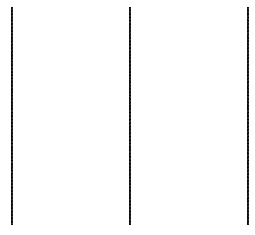

conv2d_3 (3, 3, 64, 64)
64


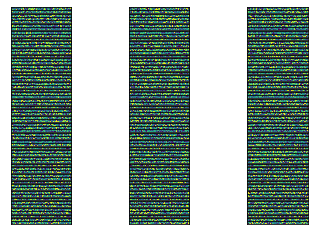

In [31]:
for layer in model.layers:
      if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        
        f_min, f_max = weights.min(), weights.max()
        
        filters = (weights - f_min) / (f_max - f_min)  
        print(layer.name, filters.shape)

        print(filters.shape[3])
        filter_cnt=1
        
        for i in range(filters.shape[3]):
            filt=filters[:,:,:, i]
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:, j])
                filter_cnt+=1
        plt.show()

In [ ]:
!tensorboard --logdir logs/scalars